# KNN Book recommendation

The Objective of this notebook will be to explore the data sets and then create a model to recommend book<br> stores what books to stock up on depending on the bookstore's location and the demographic(age) of that location.

## Setup Environment

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD

In [2]:
path = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/data/cleaned")

In [3]:
cwd = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir))

In [4]:
os.listdir(path)

['BX-Books.csv', 'BX-NewBooksRatings.csv', 'BX-Ratings.csv', 'BX-Users.csv']

#### Read in clean data

In [5]:
ratings = pd.read_csv(path + '/BX-Ratings.csv')
print(ratings.dtypes)
ratings.head()

User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object


,User-ID,ISBN,Book-Rating
0,276744,038550120X,7
1,276754,0684867621,8
2,276755,0451166892,5
3,276762,0380711524,5
4,276772,0553572369,7


In [6]:
users = pd.read_csv(path + '/BX-Users.csv')
print(users.dtypes)
users.head()

User-ID                   int64
User-City                object
User-State               object
User-Country             object
User-Age                float64
Age-Group                object
User-Info                object
User-Country-Encoded      int64
User-Info-Encoded         int64
Age-Group-Encoded         int64
dtype: object


,User-ID,User-City,User-State,User-Country,User-Age,Age-Group,User-Info,User-Country-Encoded,User-Info-Encoded,Age-Group-Encoded
0,8,timmins,ontario,canada,13.0,"(4.0, 26.0]",timmins_ontario_canada,17,11421,0
1,9,germantown,tennessee,usa,33.0,"(26.0, 34.0]",germantown_tennessee_usa,124,4225,1
2,16,albuquerque,new mexico,usa,55.0,"(46.0, 100.0]",albuquerque_new mexico_usa,124,190,3
3,17,chesapeake,virginia,usa,36.0,"(34.0, 46.0]",chesapeake_virginia_usa,124,2148,2
4,19,weston,unknown,unknown,14.0,"(4.0, 26.0]",weston_unknown_unknown,121,12473,0


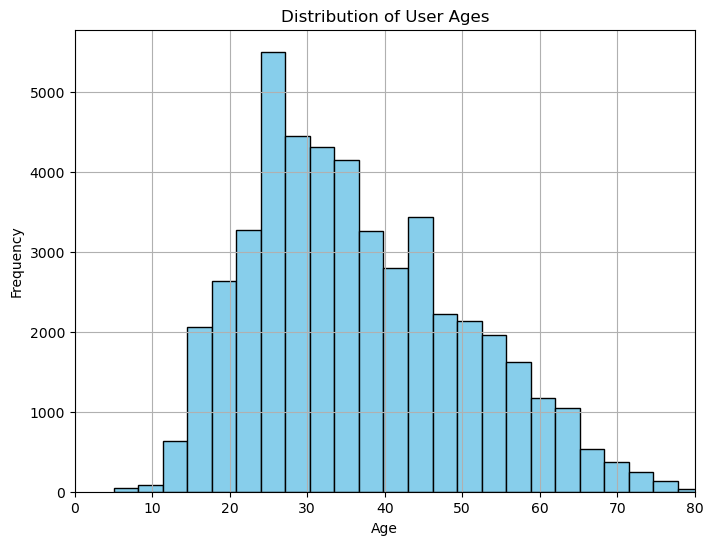

In [7]:
plt.figure(figsize=(8, 6))
plt.hist(users['User-Age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.xlim(0,80)
plt.grid(True)
plt.show()

In [8]:
books = pd.read_csv(path + '/BX-Books.csv')
print(books.dtypes)
books.head()

ISBN                                  object
Book-Title                            object
Book-Author                           object
Year-Of-Publication                  float64
Book-Publisher                        object
Book-Author-Processed                 object
Book-Publisher-Processed              object
Book-Title-Processed                  object
Book-Info                             object
Book-Vector                           object
Year-Of-Publication-Group             object
Year-Of-Publication-Group-Encoded      int64
dtype: object


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,richard bruce wright,harperflamingo canada,clara callan,clara callan by richard bruce wright,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8
1,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,gina bari kolata,farrar straus giroux,flu the story of the great influenza pandemic ...,flu the story of the great influenza pandemic ...,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7
2,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,amy tan,putnam pub group,the kitchen god s wife,the kitchen god s wife by amy tan,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7
3,0440234743,The Testament,John Grisham,1999.0,Dell,john grisham,dell,the testament,the testament by john grisham,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7
4,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994.0,Plume,toni morrison,plume,beloved plume contemporary fiction,beloved plume contemporary fiction by toni mor...,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7


We should only use ratings that are of books in our data set of books

In [9]:
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]
ratings.shape,ratings_new.shape

((204164, 3), (204164, 3))

Both ratings and ratings_new have the same shape so we can assume that all the ratings are of books in our books data set.<br>
Thats great!

Now our ratings need to be from users in our user data set

In [10]:
print("Shape of dataset before dropping",ratings_new.shape)
ratings_new = ratings_new[ratings_new['User-ID'].isin(users['User-ID'])]
print("shape of dataset after dropping",ratings_new.shape)

Shape of dataset before dropping (204164, 3)
shape of dataset after dropping (203963, 3)


Okay so all the ratings we got have their corrosponding user data, nice!

#### Analyse rating distribution

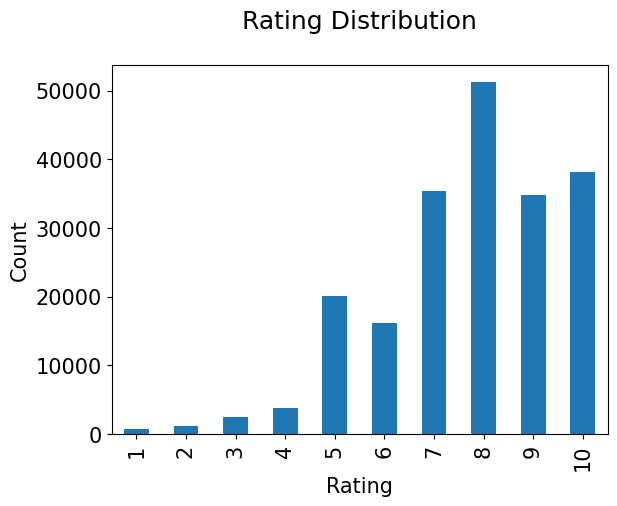

In [11]:
ratings_counts = ratings['Book-Rating'].value_counts(sort=False)

ratings_counts_sorted = ratings_counts.sort_index()

plt.rc("font", size=15)
ratings_counts_sorted.plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

It seems that the ratings are very heavily negatively skewed, this means that people will generally review books they like rather than books the don't like more often

Let's take a look at the top 5 books that have been rated the most by users

In [12]:
rating_count = pd.DataFrame(ratings.groupby('ISBN')['Book-Rating'].count())
rating_count.sort_values('Book-Rating', ascending=False).head()

,Book-Rating
ISBN,
0316666343,675
0971880107,575
0385504209,479
0312195516,362
0060928336,312


In [13]:
most_rated_books = pd.DataFrame(['0316666343', '0971880107', '0385504209', '0312195516', '0060928336'], index=np.arange(5), columns = ['ISBN'])
most_rated_books_summary = pd.merge(most_rated_books, books, on='ISBN')
most_rated_books_summary

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded
0,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",alice sebold,little brown,the lovely bone a novel,the lovely bone a novel by alice sebold,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8
1,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far,rich shapero,too far,wild animus,wild animus by rich shapero,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8
2,0385504209,The Da Vinci Code,Dan Brown,2003.0,Doubleday,dan brown,doubleday,the da vinci code,the da vinci code by dan brown,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8
3,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA,anita diamant,picador usa,the red tent bestselling backlist,the red tent bestselling backlist by anita dia...,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7
4,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,Perennial,rebecca wells,perennial,divine secret of the ya ya sisterhood a novel,divine secret of the ya ya sisterhood a novel ...,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7


Just for intuition let's see the distribution of ratings for the top book: "The Lovely Bones: A Novel"

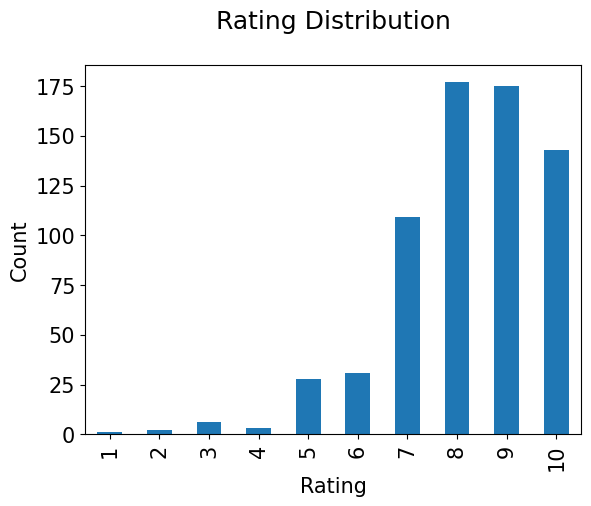

In [14]:
isbn_0316666343_df = ratings[ratings['ISBN'] == '0316666343']

isbn_0316666343_df_counts = isbn_0316666343_df['Book-Rating'].value_counts(sort=False)

isbn_0316666343_df_sorted = isbn_0316666343_df_counts.sort_index()

plt.rc("font", size=15)
isbn_0316666343_df_sorted.plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

It seems that the same trends still hold thats great!

Now let's create a new collumn in our ratings df for average rating of that book

In [15]:
# Create column Rating average 
ratings['Avg_Rating']=ratings.groupby('ISBN')['Book-Rating'].transform('mean')
# Create column Rating sum
ratings['Times been Rated']=ratings.groupby('ISBN')['Book-Rating'].transform('count')

In [16]:
ratings.head()

,User-ID,ISBN,Book-Rating,Avg_Rating,Times been Rated
0,276744,038550120X,7,7.569620,79
1,276754,0684867621,8,7.103448,58
2,276755,0451166892,5,8.383721,86
3,276762,0380711524,5,7.625000,16
4,276772,0553572369,7,6.625000,8


Okay now let's merge the data sets together for further analysis

In [17]:
Final_Dataset=users.copy()
Final_Dataset=pd.merge(Final_Dataset,ratings,on='User-ID')
Final_Dataset=pd.merge(Final_Dataset,books,on='ISBN')

In [18]:
Final_Dataset.head()

,User-ID,User-City,User-State,User-Country,User-Age,Age-Group,User-Info,User-Country-Encoded,User-Info-Encoded,Age-Group-Encoded,...,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded
0,8,timmins,ontario,canada,13.0,"(4.0, 26.0]",timmins_ontario_canada,17,11421,0,...,Richard Bruce Wright,2001.0,HarperFlamingo Canada,richard bruce wright,harperflamingo canada,clara callan,clara callan by richard bruce wright,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8
1,11676,unknown,unknown,unknown,26.0,"(4.0, 26.0]",unknown_unknown_unknown,121,11769,0,...,Richard Bruce Wright,2001.0,HarperFlamingo Canada,richard bruce wright,harperflamingo canada,clara callan,clara callan by richard bruce wright,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8
2,67544,toronto,ontario,canada,30.0,"(26.0, 34.0]",toronto_ontario_canada,17,11477,1,...,Richard Bruce Wright,2001.0,HarperFlamingo Canada,richard bruce wright,harperflamingo canada,clara callan,clara callan by richard bruce wright,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8
3,123629,kingston,ontario,canada,30.0,"(26.0, 34.0]",kingston_ontario_canada,17,5753,1,...,Richard Bruce Wright,2001.0,HarperFlamingo Canada,richard bruce wright,harperflamingo canada,clara callan,clara callan by richard bruce wright,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8
4,200273,comber,ontario,canada,24.0,"(4.0, 26.0]",comber_ontario_canada,17,2520,0,...,Richard Bruce Wright,2001.0,HarperFlamingo Canada,richard bruce wright,harperflamingo canada,clara callan,clara callan by richard bruce wright,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8


In [19]:
Final_Dataset.replace('unknown', np.nan, inplace=True)

missing_values_count = Final_Dataset.isna().sum()
total_values = len(Final_Dataset)

missing_values_percentage = (missing_values_count / total_values) * 100

missing_values_df = pd.DataFrame({'Column': missing_values_count.index, 
                                  'Missing Values': missing_values_count.values,
                                  'Missing Values (%)': missing_values_percentage.values})

missing_values_df

,Column,Missing Values,Missing Values (%)
0,User-ID,0,0.000000
1,User-City,4747,2.327383
2,User-State,11406,5.592191
3,User-Country,5680,2.784819
4,User-Age,0,0.000000
5,Age-Group,0,0.000000
6,User-Info,0,0.000000
7,User-Country-Encoded,0,0.000000
8,User-Info-Encoded,0,0.000000
9,Age-Group-Encoded,0,0.000000


It seems that there are a lot of missing values in the location collumns. Since we are trying to train our model to give recommendations based on location, I think that we should omit these rows

In [20]:
Final_Dataset.dropna(inplace=True)
missing_values_count = Final_Dataset.isna().sum()
total_values = len(Final_Dataset)

# Calculate the percentage of missing values for each column
missing_values_percentage = (missing_values_count / total_values) * 100

# Creating a new DataFrame to store the missing values count and percentage
missing_values_df = pd.DataFrame({'Column': missing_values_count.index, 
                                  'Missing Values': missing_values_count.values,
                                  'Missing Values (%)': missing_values_percentage.values})

missing_values_df

,Column,Missing Values,Missing Values (%)
0,User-ID,0,0.0
1,User-City,0,0.0
2,User-State,0,0.0
3,User-Country,0,0.0
4,User-Age,0,0.0
5,Age-Group,0,0.0
6,User-Info,0,0.0
7,User-Country-Encoded,0,0.0
8,User-Info-Encoded,0,0.0
9,Age-Group-Encoded,0,0.0


## Book recommendation system

This section we will try and transform the data to make KNN more plausible


In [21]:
ratings.head()

,User-ID,ISBN,Book-Rating,Avg_Rating,Times been Rated
0,276744,038550120X,7,7.569620,79
1,276754,0684867621,8,7.103448,58
2,276755,0451166892,5,8.383721,86
3,276762,0380711524,5,7.625000,16
4,276772,0553572369,7,6.625000,8


### Implementing Knn

Let's make a matrix of ratings and books to see what books get ratings from similar users

In [22]:
ratings_matrix = ratings.pivot(index='User-ID', columns='ISBN', values='Book-Rating')
userID = ratings_matrix.index
ISBN = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.head()

(48299, 18185)


ISBN,0002005018,0002116286,0002243962,0002251760,0002255081,0002259834,0002261820,0002550563,0002558122,0003300277,...,9681500954,968150108X,9681501225,9722016563,972210277X,9722105248,9726101794,9728423160,9812327975,9871138148
User-ID,,,,,,,,,,,,,,,,,,,,,
8,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
n_users = ratings_matrix.shape[0]
n_books = ratings_matrix.shape[1]
print (n_users, n_books)
     

48299 18185


Let's fix up those nans

In [24]:
ratings_matrix.fillna(0, inplace = True)
ratings_matrix = ratings_matrix.astype(np.int32)

In [25]:
ratings_matrix

ISBN,0002005018,0002116286,0002243962,0002251760,0002255081,0002259834,0002261820,0002550563,0002558122,0003300277,...,9681500954,968150108X,9681501225,9722016563,972210277X,9722105248,9726101794,9728423160,9812327975,9871138148
User-ID,,,,,,,,,,,,,,,,,,,,,
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278846,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
278849,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
278851,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
sparsity = 1.0-len(ratings)/float(ratings.shape[0]*n_books)
print('Matrix Sparsity:' +  str(sparsity*100))

Matrix Sparsity:99.99450096233159


This is a very high sparsity and something we need to fix to get our knn model to work better,<br> to fix this we should omit books with few ratings

In [27]:
raw_ratings = pd.read_csv(path + '/BX-Ratings.csv')


combine_book_rating = pd.merge(raw_ratings, books, on = 'ISBN')
combine_book_rating

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded
0,276744,038550120X,7,A Painted House,JOHN GRISHAM,2001.0,Doubleday,john grisham,doubleday,a painted house,a painted house by john grisham,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8
1,11676,038550120X,10,A Painted House,JOHN GRISHAM,2001.0,Doubleday,john grisham,doubleday,a painted house,a painted house by john grisham,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8
2,16877,038550120X,9,A Painted House,JOHN GRISHAM,2001.0,Doubleday,john grisham,doubleday,a painted house,a painted house by john grisham,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8
3,17975,038550120X,6,A Painted House,JOHN GRISHAM,2001.0,Doubleday,john grisham,doubleday,a painted house,a painted house by john grisham,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8
4,20806,038550120X,6,A Painted House,JOHN GRISHAM,2001.0,Doubleday,john grisham,doubleday,a painted house,a painted house by john grisham,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204159,265784,0886775809,7,"The Law of Becoming (Jaran, Book 4)",Kate Elliott,1994.0,Daw Books,kate elliott,daw books,the law of becoming jaran book 4,the law of becoming jaran book 4 by kate elliott,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7
204160,246196,0375700110,4,Half and Half: Writers on Growing Up Biracial ...,Claudine C. O'Hearn,1998.0,Pantheon Books,claudine c ohearn,pantheon books,half and half writer on growing up biracial an...,half and half writer on growing up biracial an...,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7
204161,257485,0375700110,6,Half and Half: Writers on Growing Up Biracial ...,Claudine C. O'Hearn,1998.0,Pantheon Books,claudine c ohearn,pantheon books,half and half writer on growing up biracial an...,half and half writer on growing up biracial an...,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7
204162,274666,0375700110,9,Half and Half: Writers on Growing Up Biracial ...,Claudine C. O'Hearn,1998.0,Pantheon Books,claudine c ohearn,pantheon books,half and half writer on growing up biracial an...,half and half writer on growing up biracial an...,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7


We only really care about the Book ratings and Book titles here so let's remove some distracting collumns

In [28]:
cols_to_drop = ['Book-Author', 'Book-Info', 'Year-Of-Publication', 'Book-Publisher', 'Book-Vector', 'Year-Of-Publication-Group', 'Year-Of-Publication-Group-Encoded']
combine_book_rating = combine_book_rating.drop(cols_to_drop, axis = 1)
combine_book_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed
0,276744,038550120X,7,A Painted House,john grisham,doubleday,a painted house
1,11676,038550120X,10,A Painted House,john grisham,doubleday,a painted house
2,16877,038550120X,9,A Painted House,john grisham,doubleday,a painted house
3,17975,038550120X,6,A Painted House,john grisham,doubleday,a painted house
4,20806,038550120X,6,A Painted House,john grisham,doubleday,a painted house


Let's group it by titles and find out how many times each title was reviewed

In [29]:
grouped_ratings = combine_book_rating.groupby(by=['Book-Title'])['Book-Rating'].count()
reset_index = grouped_ratings.reset_index()
renamed_columns = reset_index.rename(columns={'Book-Rating': 'Total-Rating-Count'})
book_ratingcount = renamed_columns[['Book-Title', 'Total-Rating-Count']]

In [30]:
sorted_count = book_ratingcount.sort_values(by='Total-Rating-Count', ascending=False)
sorted_count.head()

,Book-Title,Total-Rating-Count
13063,The Lovely Bones: A Novel,675
15789,Wild Animus,575
11919,The Da Vinci Code,479
13876,The Secret Life of Bees,394
13302,The Nanny Diaries: A Novel,378


In [31]:
merged_counts = combine_book_rating.merge(book_ratingcount, left_on = 'Book-Title', right_on = 'Book-Title', how = 'inner' )

merged_counts.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Total-Rating-Count
0,276744,038550120X,7,A Painted House,john grisham,doubleday,a painted house,353
1,11676,038550120X,10,A Painted House,john grisham,doubleday,a painted house,353
2,16877,038550120X,9,A Painted House,john grisham,doubleday,a painted house,353
3,17975,038550120X,6,A Painted House,john grisham,doubleday,a painted house,353
4,20806,038550120X,6,A Painted House,john grisham,doubleday,a painted house,353


Okay now let's analyse our distribution and take books that have a significant ammount of ratings

In [32]:
print(book_ratingcount['Total-Rating-Count'].describe())

count    16135.000000
mean        12.653486
std         22.815198
min          4.000000
25%          4.000000
50%          6.000000
75%         12.000000
max        675.000000
Name: Total-Rating-Count, dtype: float64


In [33]:
print(book_ratingcount['Total-Rating-Count'].quantile(np.arange(.9,1,.01)))

0.90     24.00
0.91     26.00
0.92     28.00
0.93     31.00
0.94     35.00
0.95     39.00
0.96     47.00
0.97     58.00
0.98     75.00
0.99    106.66
Name: Total-Rating-Count, dtype: float64


It seems that only a few books have significant amount of ratings. Because we have so many books, let's take the top 4% of books, that is the books that receive 47 or more ratings

In [34]:
popularity_threshold = 47
rating_popular_book = merged_counts[merged_counts['Total-Rating-Count'] >= popularity_threshold]

In [35]:
ratings_removed = len(merged_counts) - len(rating_popular_book)
print('ratings_removed =', ratings_removed)

rating_popular_book.tail()

ratings_removed = 141014


,User-ID,ISBN,Book-Rating,Book-Title,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Total-Rating-Count
158547,254299,0446394521,5,Daisy Fay and the Miracle Man,fannie flagg,warner books,daisy fay and the miracle man,56
158548,254822,0446394521,7,Daisy Fay and the Miracle Man,fannie flagg,warner books,daisy fay and the miracle man,56
158549,255814,0446394521,8,Daisy Fay and the Miracle Man,fannie flagg,warner books,daisy fay and the miracle man,56
158550,258614,0446394521,8,Daisy Fay and the Miracle Man,fannie flagg,warner books,daisy fay and the miracle man,56
158551,263877,0446394521,7,Daisy Fay and the Miracle Man,fannie flagg,warner books,daisy fay and the miracle man,56


Now let's check and remove any duplicate rows

In [36]:
duplicate_rows = rating_popular_book.duplicated(['User-ID', 'Book-Title'])

# Count the number of duplicate rows
num_duplicates = duplicate_rows.sum()

print("Number of duplicate rows:", num_duplicates)
print(rating_popular_book.shape)

Number of duplicate rows: 341
(63150, 8)


In [37]:
if not rating_popular_book[rating_popular_book.duplicated(['User-ID', 'Book-Title'])].empty:
    rating_popular_book = rating_popular_book.drop_duplicates(['User-ID', 'Book-Title'])
print(rating_popular_book.shape)

(62809, 8)


#### And Now we have our Matrix!

In [38]:
user_rating_matrix = rating_popular_book.pivot(index = 'Book-Title',columns = 'User-ID', values = 'Book-Rating').fillna(0)
user_rating_matrix

User-ID,9,16,26,32,39,42,51,97,99,114,...,278800,278807,278824,278828,278832,278836,278843,278844,278846,278854
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Wizard and Glass (The Dark Tower, Book 4)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wuthering Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Year of Wonders,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
total_elements = user_rating_matrix.size
num_zero_elements = np.count_nonzero(user_rating_matrix == 0)
sparsity = num_zero_elements / total_elements
sparsity

0.9960415117846467

This Sparsity is barely acceptable, we could increase our threshhold but this will come at the cost of ignoring less popular books and therefore decrease out book set

### K nearest neighbours

Training Model

In [40]:
X = user_rating_matrix.values
X.shape

(663, 23932)

In [41]:
SVD = TruncatedSVD(n_components=12, random_state=123)
matrix = SVD.fit_transform(X)
print(matrix.shape)
matrix

(663, 12)


array([[ 18.43010252,  -0.64821645,  -5.11985322, ...,   5.63786148,
          0.80882637,  -5.06073329],
       [ 24.53075555,  -8.89833749, -12.95587916, ...,   3.40514249,
          2.81280698,   5.45309695],
       [ 18.56935687,  -7.16504849,  -9.71963061, ...,   0.88318189,
         -0.38541845,   4.27453152],
       ...,
       [  8.77695273,  -3.80742528,   3.50362653, ...,   0.33147606,
          1.5972747 ,   3.39248108],
       [  8.54398378,  -0.50572805,  -1.83968537, ...,   0.44727056,
          1.15177912,   0.34919366],
       [ 12.39535404,  -1.24456853,  -6.71079979, ...,   3.2412674 ,
          0.89082545,  -1.80804897]])

In [42]:
corr = np.corrcoef(matrix)
corr.shape

(663, 663)

Test out Model

In [43]:
book_titles = user_rating_matrix.index
book_list = list(book_titles)
test_book = 'Harry Potter and the Prisoner of Azkaban (Book 3)'

knn_model = NearestNeighbors(n_neighbors=3, metric='cosine')

knn_model.fit(corr)
matrix_index = book_list.index(test_book)
distances, indices = knn_model.kneighbors([corr[matrix_index]], n_neighbors=5+1)
recommended_indices = indices[0][1:] 
recommended_books = [book_list[idx] for idx in recommended_indices]
print("Recommended books similar to " + test_book)
for book in recommended_books:
    print("-", book)


Recommended books similar to 'Harry Potter and the Prisoner of Azkaban (Book 3)':
- Harry Potter and the Chamber of Secrets (Book 2)
- Harry Potter and the Goblet of Fire (Book 4)
- Harry Potter and the Order of the Phoenix (Book 5)
- Harry Potter and the Sorcerer's Stone (Book 1)
- The Bad Beginning (A Series of Unfortunate Events, Book 1)


Nice similar books are being recommended

## Implement Recommendation System

In [66]:
def book_recommendations(Final_Data,corr, knn_model, book_titles ,target ) -> list:
    recommended_books = []
    book_list = list(book_titles)

    target_reviews = Final_Data[Final_Data['User-ID']==target]
    for index, row in target_reviews.iterrows():
        recommended_books.append(row['Book-Title'])
        if row['Book-Title'] in book_list:
            matrix_index = book_list.index(row['Book-Title'])
            distances, indices = knn_model.kneighbors([corr[matrix_index]], n_neighbors=4+1)
            recommended_indices = indices[0][1:] 
            related_books = [book_list[idx] for idx in recommended_indices]
            for book in related_books:
                recommended_books.append(book)

    recommended_books = set(recommended_books)



    return recommended_books


In [69]:
user = 276794 #input user id with at least one rating
recommended_books = book_recommendations(Final_Dataset,corr, knn_model, user_rating_matrix.index, user)

In [68]:
print(len(recommended_books))
recommended_books

5


{"Angela's Ashes: A Memoir",
 'Breath, Eyes, Memory',
 'Daisy Fay and the Miracle Man',
 'The Pillars of the Earth',
 "White Oleander : A Novel (Oprah's Book Club)"}

## Accuracy Testing via LOOCV:

to test the precision of our model, we will employ Leave one out cross validation, that is we will iterate through out users, with more than 20 ratings, choose one target and see based off the other books if we are able to predict that given book

In [47]:
def test_recommendation(merged_data, corr_matrix, book_titles ,user_ID):

    book_list = list(book_titles)
    user_reviews = merged_data[merged_data['User-ID']==user_ID]
    user_books = []

    for index, row in user_reviews.iterrows():
        user_books.append(row['Book-Title']) 
    target_book = user_books[0] # we just take the first book without loss of generality
    test_books = user_books[1:]

    for book in test_books:
        if book in book_list:
            matrix_index = book_list.index(book)
            book_row = corr_matrix[matrix_index]
            related_books = list(book_titles[(book_row<1.0) & (book_row>0.7)])
            if target_book in related_books:
                return 1

    
    return 0

In [48]:
Final_Dataset.head()

,User-ID,User-City,User-State,User-Country,User-Age,Age-Group,User-Info,User-Country-Encoded,User-Info-Encoded,Age-Group-Encoded,...,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded
0,8,timmins,ontario,canada,13.0,"(4.0, 26.0]",timmins_ontario_canada,17,11421,0,...,Richard Bruce Wright,2001.0,HarperFlamingo Canada,richard bruce wright,harperflamingo canada,clara callan,clara callan by richard bruce wright,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8
2,67544,toronto,ontario,canada,30.0,"(26.0, 34.0]",toronto_ontario_canada,17,11477,1,...,Richard Bruce Wright,2001.0,HarperFlamingo Canada,richard bruce wright,harperflamingo canada,clara callan,clara callan by richard bruce wright,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8
3,123629,kingston,ontario,canada,30.0,"(26.0, 34.0]",kingston_ontario_canada,17,5753,1,...,Richard Bruce Wright,2001.0,HarperFlamingo Canada,richard bruce wright,harperflamingo canada,clara callan,clara callan by richard bruce wright,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8
4,200273,comber,ontario,canada,24.0,"(4.0, 26.0]",comber_ontario_canada,17,2520,0,...,Richard Bruce Wright,2001.0,HarperFlamingo Canada,richard bruce wright,harperflamingo canada,clara callan,clara callan by richard bruce wright,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8
5,210926,guelph,ontario,canada,24.0,"(4.0, 26.0]",guelph_ontario_canada,17,4596,0,...,Richard Bruce Wright,2001.0,HarperFlamingo Canada,richard bruce wright,harperflamingo canada,clara callan,clara callan by richard bruce wright,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8


In [49]:
user_ratings_count = Final_Dataset.groupby('User-ID').size()
users_with_more_than_50_ratings = user_ratings_count[user_ratings_count > 50].index
test_targets = Final_Dataset[Final_Dataset['User-ID'].isin(users_with_more_than_50_ratings)]
test_targets.sort_values(by='User-ID')


,User-ID,User-City,User-State,User-Country,User-Age,Age-Group,User-Info,User-Country-Encoded,User-Info-Encoded,Age-Group-Encoded,...,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded
5041,2033,omaha,nebraska,usa,27.0,"(26.0, 34.0]",omaha_nebraska_usa,124,8429,1,...,J. K. Rowling,1999.0,Scholastic,j k rowling,scholastic,harry potter and the prisoner of azkaban book 3,harry potter and the prisoner of azkaban book ...,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7
34505,2033,omaha,nebraska,usa,27.0,"(26.0, 34.0]",omaha_nebraska_usa,124,8429,1,...,Jacqueline Carey,2003.0,Tor Fantasy,jacqueline carey,tor fantasy,kushiel s chosen kushiel s legacy,kushiel s chosen kushiel s legacy by jacquelin...,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8
34481,2033,omaha,nebraska,usa,27.0,"(26.0, 34.0]",omaha_nebraska_usa,124,8429,1,...,Jacqueline Carey,2002.0,Tor Books,jacqueline carey,tor books,kushiel s dart,kushiel s dart by jacqueline carey,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8
34477,2033,omaha,nebraska,usa,27.0,"(26.0, 34.0]",omaha_nebraska_usa,124,8429,1,...,James Eade,1996.0,For Dummies,james eade,for dummies,chess for dummy,chess for dummy by james eade,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7
34472,2033,omaha,nebraska,usa,27.0,"(26.0, 34.0]",omaha_nebraska_usa,124,8429,1,...,Robin McKinley,2002.0,Firebird,robin mckinley,firebird,spindle s end,spindle s end by robin mckinley,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66255,277427,gilbert,arizona,usa,48.0,"(46.0, 100.0]",gilbert_arizona_usa,124,4250,3,...,T. H. White,1987.0,Ace Books,t h white,ace books,the once and future king,the once and future king by t h white,[0. 0. 0. ... 0. 0. 0.],"(1979, 1989]",6
175776,277427,gilbert,arizona,usa,48.0,"(46.0, 100.0]",gilbert_arizona_usa,124,4250,3,...,Sheri S. Tepper,1998.0,Eos,sheri s tepper,eos,the family tree,the family tree by sheri s tepper,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7
200729,277427,gilbert,arizona,usa,48.0,"(46.0, 100.0]",gilbert_arizona_usa,124,4250,3,...,Walter Mosley,1992.0,Pocket,walter mosley,pocket,red death featuring an original easy rawlins s...,red death featuring an original easy rawlins s...,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7
86566,277427,gilbert,arizona,usa,48.0,"(46.0, 100.0]",gilbert_arizona_usa,124,4250,3,...,Laura Childs,2003.0,Berkley Publishing Group,laura childs,berkley publishing group,keepsake crime first scrapbooking mystery,keepsake crime first scrapbooking mystery by l...,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8


In [71]:
test_ids = test_targets['User-ID'].tolist()

user_id_set = set(test_ids)
user_id_set

{16795,
 35859,
 95359,
 98391,
 104636,
 114368,
 123883,
 153662,
 158295,
 204864,
 235105}

In [72]:
test_recommendation(Final_Dataset, corr, user_rating_matrix.index, 274301)

1

In [52]:
results = []
for id in user_id_set:
    match = test_recommendation(Final_Dataset, corr, user_rating_matrix.index, id)
    if match == 0:  
        results.append(0)  
    else:
        results.append(1)



In [53]:
results_array = np.array(results)
results_array.mean()


0.6820083682008368

In [55]:
review_count_index = []
accuracy = []
for value in range(10, 301, 10):
    review_count_index.append(value)


for i in range(len(review_count_index)):
    user_ratings_count = Final_Dataset.groupby('User-ID').size()
    users_with_more_than_50_ratings = user_ratings_count[user_ratings_count > review_count_index[i]].index
    test_targets = Final_Dataset[Final_Dataset['User-ID'].isin(users_with_more_than_50_ratings)]
    test_ids = test_targets['User-ID'].tolist()
    user_id_set = set(test_ids)
    results = []
    for id in user_id_set:
        match = test_recommendation(Final_Dataset, corr, user_rating_matrix.index, id)
        if match == 0:  
            results.append(0)  
        else:
            results.append(1)
    results_array = np.array(results)
    mean = results_array.mean()
    accuracy.append(mean)
    

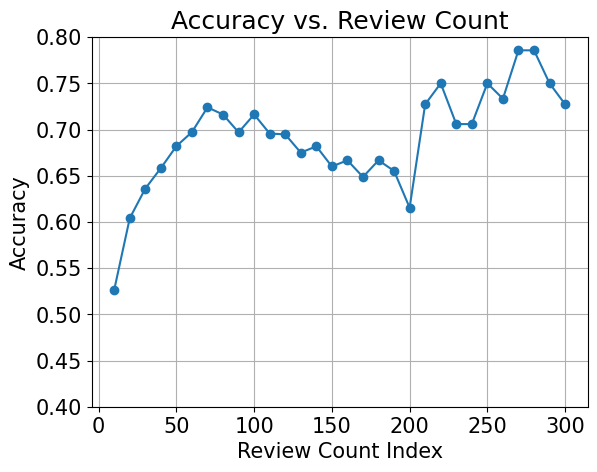

In [ ]:
plt.plot(review_count_index, accuracy, marker='o', linestyle='-')
plt.title('Accuracy vs. Review Count')
plt.xlabel('Review Count Index')
plt.ylabel('Accuracy')
plt.ylim(0.4,0.8)
plt.grid(True)
plt.show()